<a href="https://colab.research.google.com/github/Rhanbouri/Stock-Return-Prediction/blob/main/QRT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
from collections import Counter

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch.optim as optim

## Loading data

In [ ]:
x_train = pd.read_csv('/content/drive/MyDrive/challenge Stock prediction/x_train.csv', index_col='ID')
y_train = pd.read_csv('/content/drive/MyDrive/challenge Stock prediction/y_train.csv', index_col='ID')
train = pd.concat([x_train, y_train], axis=1)
test = pd.read_csv('/content/drive/MyDrive/challenge Stock prediction/x_test.csv', index_col='ID')
train.head()

,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,VOLUME_2,RET_3,VOLUME_3,RET_4,VOLUME_4,RET_5,VOLUME_5,RET_6,VOLUME_6,RET_7,VOLUME_7,RET_8,VOLUME_8,RET_9,VOLUME_9,RET_10,VOLUME_10,RET_11,VOLUME_11,RET_12,VOLUME_12,RET_13,VOLUME_13,RET_14,VOLUME_14,RET_15,VOLUME_15,RET_16,VOLUME_16,RET_17,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20,RET
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,2,18,5,3,44,-0.015748,0.147931,-0.015504,0.179183,0.010972,0.033832,-0.014672,-0.362868,0.016483,-0.972920,0.014331,0.590810,-0.017215,0.557246,-0.018433,0.453590,0.134146,8.580442,0.182287,3.427303,0.013570,-0.328418,0.030108,-0.816436,0.027624,-0.244636,-0.049370,-2.042624,-0.028571,-0.369605,0.059459,0.630899,0.003254,-0.379412,0.008752,-0.110597,-0.012959,0.174521,-0.002155,-0.000937,True
1,0,3,43,15,6,104,0.003984,NaN,-0.090580,NaN,0.018826,NaN,-0.025540,NaN,-0.038062,NaN,-0.006873,NaN,-0.026756,NaN,0.023973,NaN,0.158731,NaN,0.045642,NaN,-0.008230,NaN,-0.028000,NaN,-0.019608,NaN,-0.052044,NaN,-0.004073,NaN,0.015413,NaN,0.003774,NaN,-0.018518,NaN,-0.028777,NaN,-0.034722,NaN,True
2,0,4,57,20,8,142,0.000440,-0.096282,-0.058896,0.084771,-0.009042,-0.298777,0.024852,-0.157421,0.009354,0.091455,0.027522,-0.405978,-0.023047,-0.389777,-0.002979,-0.701838,-0.006342,-0.229531,0.055803,0.543460,-0.012781,-0.121126,0.028093,-0.187444,-0.009426,-0.081783,-0.002686,-0.356711,-0.007552,-0.336773,0.008964,-0.010336,-0.017612,-0.354333,-0.006562,-0.519391,-0.012101,-0.356157,-0.006867,-0.308868,False
3,0,8,1,1,1,2,0.031298,-0.429540,0.007756,-0.089919,-0.004632,-0.639737,-0.019677,-0.940163,0.003544,-0.882464,-0.002021,-0.113951,-0.043962,-0.395345,-0.004329,-0.765754,0.014146,-0.593888,-0.021946,0.588171,0.007693,-0.427358,0.007264,-0.540519,-0.010067,-0.839232,0.000479,-2.144763,0.021057,-0.431029,-0.031769,0.012105,0.033824,-0.290178,-0.001468,-0.663834,-0.013520,-0.562126,-0.036745,-0.631458,False
4,0,14,36,12,5,92,0.027273,-0.847155,-0.039302,-0.943033,0.000000,-1.180629,0.000000,-1.313896,0.022321,-1.204398,0.018182,-0.879172,-0.026549,-0.858613,-0.017391,-0.029690,-0.008621,-1.022991,0.022026,-0.387114,-0.008734,-0.288180,-0.004348,-0.115091,-0.041667,0.271702,0.095891,18.894266,-0.026667,0.803608,-0.038461,-0.277083,-0.012659,0.139086,0.004237,-0.017547,0.004256,0.579510,-0.040817,0.802806,False


# Exploratory data analysis

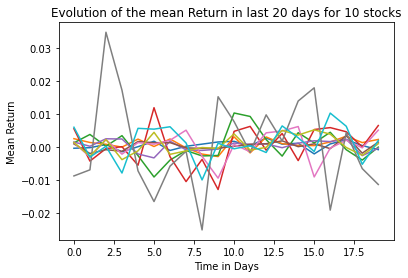

In [ ]:
n_shifts = 20 
features_RET = ['RET_%d' % (i + 1) for i in range(n_shifts)]
features_volume = ['VOLUME_%d' % (i + 1) for i in range(n_shifts)]
viz = x_train.groupby(['STOCK']).mean()[features_RET]
for i in range(10):
  plt.plot(viz.iloc[i].values)
plt.title('Evolution of the mean Return in last 20 days for 10 stocks')
plt.xlabel('Time in Days')
plt.ylabel('Mean Return')
plt.show()

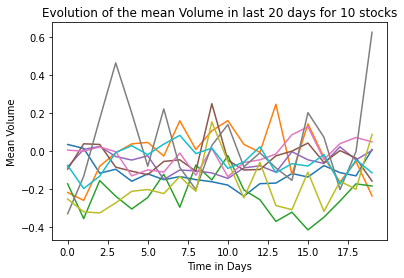

In [ ]:
viz = x_train.groupby(['STOCK']).mean()[features_volume]
for i in range(10):
  plt.plot(viz.iloc[i].values)
plt.title('Evolution of the mean Volume in last 20 days for 10 stocks')
plt.xlabel('Time in Days')
plt.ylabel('Mean Volume')
plt.show()

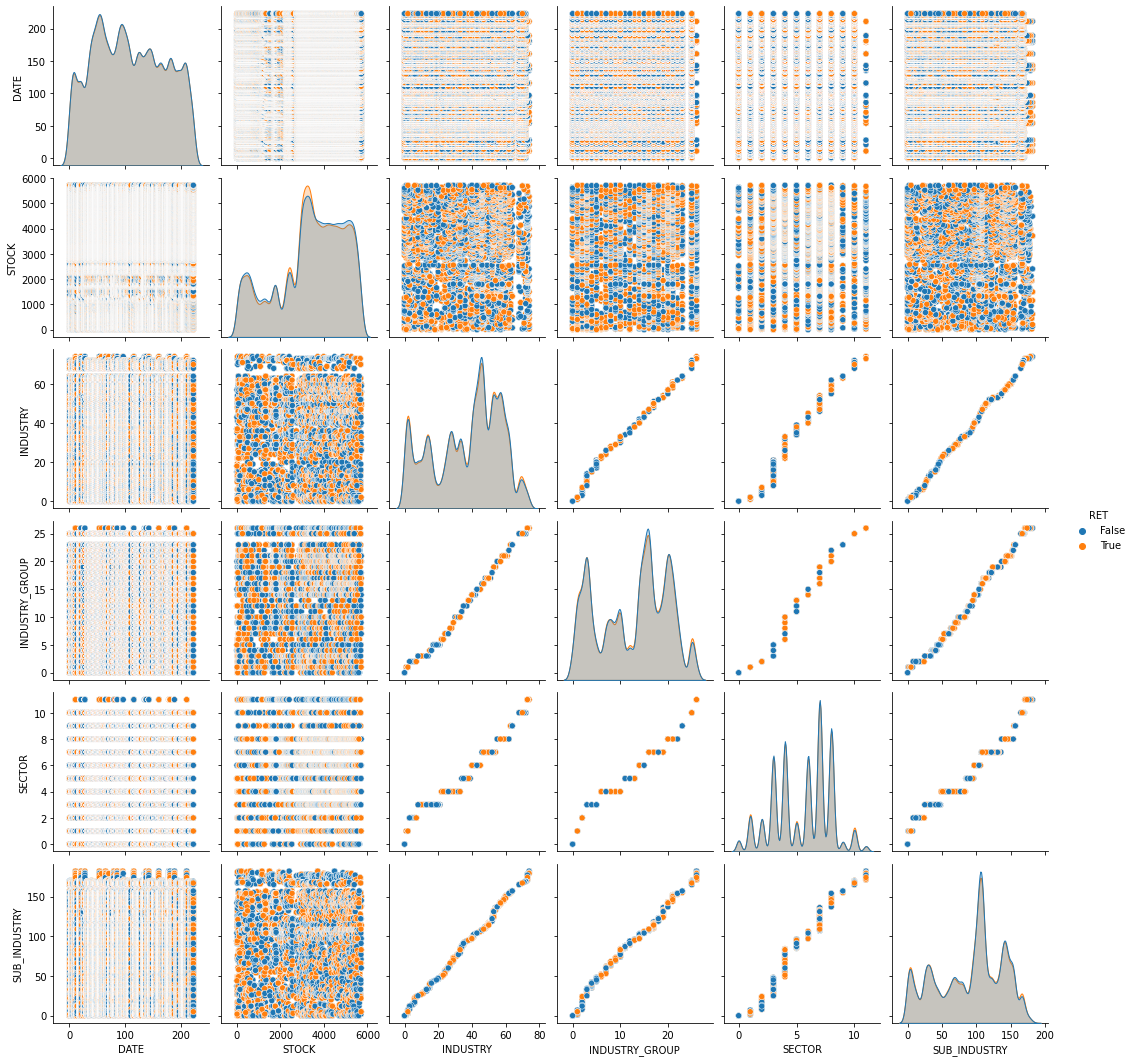

In [ ]:
# Visualization of pair plots
features_viz = ['DATE', 'STOCK', 'INDUSTRY', 'INDUSTRY_GROUP',
                'SECTOR', 'SUB_INDUSTRY', 'RET']
train_vis = x_train[features_viz].copy()
sns.pairplot(train_vis, hue ='RET')

In [ ]:
clean_train = train.fillna(value= 0)
clean_train.RET = clean_train["RET"].astype(int)
y_clean = clean_train.RET
clean_train.drop(columns=['RET'], inplace=True)

# Baseline model

for our baseline, and since we have some sequences in the data, we choosed to use a LSTM model and train it based in Return sequences.

In [ ]:
c=[]
for i in range(20):
  h=f'RET_{i+1}'
  c.append(h)
X_ret = clean_train[c]
X_ret = np.array(X_ret).reshape((len(X_ret),20,1))
y_clean = y_clean.values

In [ ]:
X_ret, valid_x, y_ret, valid_y = train_test_split(X_ret,y_clean, shuffle=True, train_size=0.8)

In [ ]:
X_ret = torch.tensor(X_ret, dtype=torch.float32)
y_ret = torch.tensor(y_ret, dtype=torch.float32)
train_ds = TensorDataset(X_ret, y_ret)
x_val = torch.tensor(valid_x, dtype=torch.float32)
y_val = torch.tensor(valid_y, dtype=torch.float32)
val_ds = TensorDataset(x_val, y_val)

In [ ]:
# DataLoaders
bs = 16
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=2*bs)

In [ ]:
import torch.nn as nn
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=1):
        # input_size = dernière dimension de ma donnée séquentielle (nombre de variable d'entrées)
        super().__init__()
        self.hidden_size = hidden_size # dimension de ma couche cachée (couche de LSTM)
        self.output_size = output_size # output_size = dimension de la sortie du réseau. 
        self.num_layers = num_layers # nombre de couches. 
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True) # by default Pytorch process input data with the sequential dim as the first dimension of the tensor. 
        # lstm outputs the last hidden representation of dimension hidden size. 
        self.fc = nn.Linear(in_features=hidden_size, out_features=output_size) # dense layer to have output of dim output size. 
        

    def forward(self, input):
        output, hidden = self.lstm(input) (B,s,output_size) 
        logits = self.fc(output[:,-1,:])  # (B,output_size)
        #logits = logits.view(-1, self.output_size)  # (B, out_features)
        return logits

In [ ]:
lstm = LSTMModel(input_size=1, hidden_size=1, output_size=2, num_layers=3).to(device)

In [ ]:
# test forward pass
xb , yb = next(iter(train_dl)) # selects randomly a batch of the train dataloader
pred = lstm(xb.to(device))
print(pred.shape)

torch.Size([16, 2])


In [ ]:
optimizer = optim.Adam(lstm.parameters(), lr = 0.001) # lr = 0.001 default learning rate of Adam. 
EPOCHS = 10
criterion = nn.CrossEntropyLoss()

In [ ]:
print("starting training ...")
train_mse_history, val_mse_history = [], [] # stock historic of the loss to plot. 
for epoch in range(EPOCHS):
  train_loss = 0
  lstm.train() # in case of dropout. 
  for (datapoints, labels) in train_dl: # loop over batches
      datapoints, labels = datapoints.to(device), labels.to(device)
      optimizer.zero_grad() # equivalent to model.zero_grad()
      preds = lstm(datapoints) # (B*S, F=1)
      #labels = labels.type(torch.long)
      loss = criterion(preds, labels.type(torch.long))
      loss.backward()
      optimizer.step()
      train_loss += loss.cpu().item()
  with torch.no_grad(): 
    val_loss = 0
    for xb, yb in val_dl:
      lstm.eval()
      xb = xb.to(device)
      yb = yb.to(device)
      val_loss += criterion(lstm(xb), yb.type(torch.long)).cpu().item()
  train_mse_history.append(train_loss / len(train_dl)) # mean of the loss over all the batches. 
  val_mse_history.append(val_loss / len(val_dl))
  print("Epoch: {}/{}".format(str(epoch + 1), EPOCHS))
  print("Train Loss: {:.4f}".format(train_loss / len(train_dl)))
  print("Val Loss: {:.4f}".format(val_loss / len(val_dl)))

starting training ...
Epoch: 1/10
Train Loss: 0.6934
Val Loss: 0.6934
Epoch: 2/10
Train Loss: 0.6932
Val Loss: 0.6932
Epoch: 3/10
Train Loss: 0.6933
Val Loss: 0.6932
Epoch: 4/10
Train Loss: 0.6933
Val Loss: 0.6932
Epoch: 5/10
Train Loss: 0.6933
Val Loss: 0.6932
Epoch: 6/10
Train Loss: 0.6933
Val Loss: 0.6934
Epoch: 7/10
Train Loss: 0.6933
Val Loss: 0.6932
Epoch: 8/10
Train Loss: 0.6933
Val Loss: 0.6935
Epoch: 9/10
Train Loss: 0.6933
Val Loss: 0.6932
Epoch: 10/10
Train Loss: 0.6933
Val Loss: 0.6932


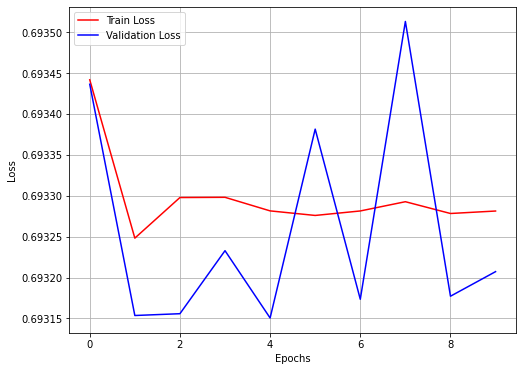

In [ ]:
# plot loss
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(range(EPOCHS), train_mse_history , color='r')
plt.plot(range(EPOCHS), val_mse_history, color='b')
plt.legend(["Train Loss", "Validation Loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
ax.grid(True)

In [ ]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [ ]:
to_test = DataLoader(val_ds, batch_size=len(val_ds))
for xb, yb in to_test:
      lstm.eval()
      xb = xb.to(device)
      yb = yb.to(device)
      print(f' The mean accuracy in test set is {accuracy(lstm(xb), yb).item()}')

 The mean accuracy in test set is 0.5003404021263123


In [ ]:
c=[]
for i in range(20):
  h=f'RET_{i+1}'
  c.append(h)
X_test = test[c]
X_test = np.array(X_test).reshape((len(X_test),20,1))

In [ ]:
X_test = torch.tensor(X_test, dtype=torch.float32)
test_ds = TensorDataset(X_test)
test_dl = DataLoader(test_ds, batch_size=len(test_ds))

In [ ]:
out = lstm(X_test.to(device))
preds = torch.argmax(out, dim=1)
preds

tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')

# lstm and static params

In [ ]:
clean_train = train.fillna(value= 0)
target = clean_train["RET"].astype(int)
clean_train.drop(columns=['RET'], inplace=True)

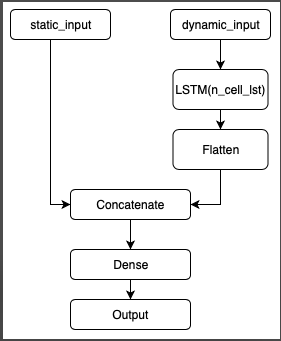

In [ ]:
static = ['DATE', 'STOCK', 'INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR', 'SUB_INDUSTRY']
static_data = np.array(clean_train[static])

c=[]
for i in range(20):
  c = c + [f'RET_{i+1}']
X_ret = clean_train[c]
X_ret = np.array(X_ret).reshape((len(X_ret),20,1))

c=[]
for i in range(20):
  c = c + [f'VOLUME_{i+1}']
X_vol = clean_train[c]
X_vol = np.array(X_vol).reshape((len(X_vol),20,1))

X_seq = np.concatenate((X_ret,X_vol), axis = 2)
target = target.values

In [ ]:
train_seq, valid_seq, train_st, valid_st, train_y, valid_y = train_test_split(X_seq, 
                                                  static_data,target, shuffle=True, train_size=0.85)

In [ ]:
train_seq = torch.tensor(train_seq, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.float32)
train_st = torch.tensor(train_st, dtype=torch.float32)
train_ds = TensorDataset(train_seq, train_st, train_y)

valid_seq = torch.tensor(valid_seq, dtype=torch.float32)
valid_st = torch.tensor(valid_st, dtype=torch.float32)
valid_y = torch.tensor(valid_y, dtype=torch.float32)
val_ds = TensorDataset(valid_seq, valid_st, valid_y)

In [ ]:
# DataLoaders
bs = 16
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=2*bs)

In [ ]:
class LSTMModel_stat(nn.Module):
    def __init__(self, input1_size, input2_size, hidden_size, output_size=2, num_layers=1, seq_len = 20):
        super().__init__()
        self.seq_len = seq_len
        self.hidden_size = hidden_size 
        self.output_size = output_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input1_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True) 
        self.fc = nn.Linear(in_features=seq_len + input2_size, out_features=output_size) 

    def forward(self, input_seq, input_static):
        output, hidden = self.lstm(input_seq) # (B,s,hidden) 
        repres =  output.view(-1, self.seq_len) # (B,s)
        logits = torch.cat((repres, input_static),1)     # (B,s+features)
        logits = self.fc(logits) # (B,2)
        return logits

In [ ]:
lstm = LSTMModel_stat(input1_size=2,input2_size=6, hidden_size=1,
                      output_size=2, num_layers=3, seq_len = 20).to(device)

In [ ]:
# test forward pass
xb_seq, xb_stat , yb = next(iter(train_dl))
pred = lstm(xb_seq.to(device), xb_stat.to(device))
print(pred.shape)

torch.Size([16, 2])


In [ ]:
optimizer = optim.Adam(lstm.parameters(), lr = 0.001) # lr = 0.001 default learning rate of Adam. 
EPOCHS = 10
criterion = nn.CrossEntropyLoss()

In [ ]:
print("starting training ...")
train_mse_history, val_mse_history = [], []
for epoch in range(EPOCHS):
  train_loss = 0
  lstm.train()
  for (datapoints_seq, datapoints_stat, labels) in train_dl:
      datapoints_seq,datapoints_stat, labels = datapoints_seq.to(device),datapoints_stat.to(device), labels.to(device)
      optimizer.zero_grad()
      preds = lstm(datapoints_seq,datapoints_stat)
      loss = criterion(preds, labels.type(torch.long))
      loss.backward()
      optimizer.step()
      train_loss += loss.cpu().item()
  with torch.no_grad(): 
    val_loss = 0
    for xb_seq, xb_stat, yb in val_dl:
      lstm.eval()
      xb_seq = xb_seq.to(device)
      xb_stat = xb_stat.to(device)
      yb = yb.to(device)
      val_loss += criterion(lstm(xb_seq, xb_stat), yb.type(torch.long)).cpu().item()
  train_mse_history.append(train_loss / len(train_dl))
  val_mse_history.append(val_loss / len(val_dl))
  print("Epoch: {}/{}".format(str(epoch + 1), EPOCHS))
  print("Train Loss: {:.4f}".format(train_loss / len(train_dl)))
  print("Val Loss: {:.4f}".format(val_loss / len(val_dl)))

starting training ...
Epoch: 1/10
Train Loss: 1.0969
Val Loss: 0.7025
Epoch: 2/10
Train Loss: 0.8636
Val Loss: 0.7405
Epoch: 3/10
Train Loss: 0.8662
Val Loss: 0.9812
Epoch: 4/10
Train Loss: 0.8770
Val Loss: 0.7345
Epoch: 5/10
Train Loss: 0.8633
Val Loss: 0.7004
Epoch: 6/10
Train Loss: 0.8707
Val Loss: 0.6989
Epoch: 7/10
Train Loss: 0.8684
Val Loss: 0.7590
Epoch: 8/10
Train Loss: 0.8682
Val Loss: 0.7499
Epoch: 9/10
Train Loss: 0.8614
Val Loss: 0.6961
Epoch: 10/10
Train Loss: 0.8640
Val Loss: 0.7411


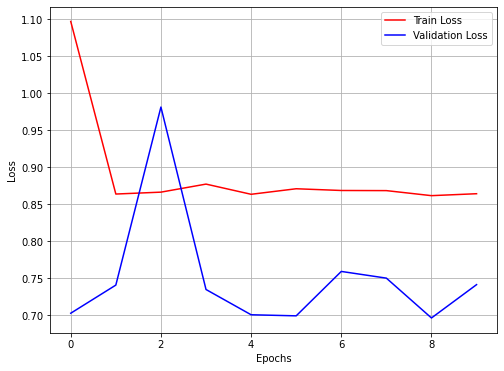

In [ ]:
# plot loss
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(range(EPOCHS), train_mse_history , color='r')
plt.plot(range(EPOCHS), val_mse_history, color='b')
plt.legend(["Train Loss", "Validation Loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
ax.grid(True)

In [ ]:
to_test = DataLoader(val_ds, batch_size=len(val_ds))
for xb_seq, xb_stat, yb in to_test:
      lstm.eval()
      xb_seq = xb_seq.to(device)
      xb_stat = xb_stat.to(device)
      yb = yb.to(device)
      print(f' The mean accuracy in validation set is {accuracy(lstm(xb_seq, xb_stat), yb).item()}')

 The mean accuracy in validation set is 0.49971336126327515


In [ ]:
to_test = DataLoader(train_ds, batch_size=len(train_ds))
for xb_seq, xb_stat, yb in to_test:
      lstm.eval()
      xb_seq = xb_seq.to(device)
      xb_stat = xb_stat.to(device)
      yb = yb.to(device)
      print(f' The mean accuracy in validation set is {accuracy(lstm(xb_seq, xb_stat), yb).item()}')

 The mean accuracy in validation set is 0.4990711212158203


In [ ]:
for xb_seq, xb_stat, yb in to_test:
  out = lstm(xb_seq.to(device), xb_stat.to(device))
  preds = torch.argmax(out, dim=1)
  actual = np.array(yb)
  print(classification_report(actual,preds.cpu()))

              precision    recall  f1-score   support

         0.0       0.59      0.00      0.01     31457
         1.0       0.50      1.00      0.67     31333

    accuracy                           0.50     62790
   macro avg       0.55      0.50      0.34     62790
weighted avg       0.55      0.50      0.34     62790



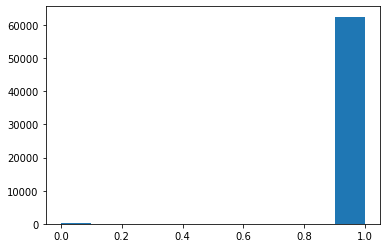

In [ ]:
plt.hist(np.array(preds.cpu()));

In [ ]:
out = lstm(X_test.to(device))
preds = torch.argmax(out, dim=1)
preds

In [ ]:
submission = pd.DataFrame(index = test.index)
submission['RET'] = True
submission.to_csv('submission.csv')

# Random Forest Classifier

## Baseline

We use cross validation with 5 folders to obtain a confident accuracy.

In [ ]:
# A quiet large number of trees with low depth to prevent overfits
rf_params = {
    'n_estimators': 500,
    'max_depth': 2**3,
    'random_state': 0,
    'n_jobs': -1
}
n_splits = 5
scores = []
models = []
reports = []

splits = KFold(n_splits=n_splits, random_state=0, shuffle=True).split(clean_train)

for i, (train_ids, test_ids) in enumerate(splits):
    local_train = clean_train.iloc[train_ids]
    local_test = clean_train.iloc[test_ids]

    y_local_train = y_clean.loc[train_ids].values
    y_local_test = y_clean.loc[test_ids].values

    model = RandomForestClassifier(**rf_params)
    model.fit(local_train, y_local_train)

    y_local_pred = model.predict_proba(local_test)[:, 1]
    y_local_pred = y_local_pred > np.median(y_local_pred)

    models.append(model)
    score = accuracy_score(y_local_test, y_local_pred)
    scores.append(score)
    print('------------------')
    print(f"Fold {i+1} - Accuracy: {score* 100:.2f}%")
    report = classification_report(y_local_test, y_local_pred)
    reports.append(report)
    print(report)

mean = np.mean(scores)*100
std = np.std(scores)*100
u = (mean + std)
l = (mean - std)
print('------------------')
print(f'Accuracy: {mean:.2f}% [{l:.2f} ; {u:.2f}] (+- {std:.2f})')

------------------
Fold 1 - Accuracy: 53.60%
              precision    recall  f1-score   support

           0       0.54      0.54      0.54     41792
           1       0.54      0.54      0.54     41927

    accuracy                           0.54     83719
   macro avg       0.54      0.54      0.54     83719
weighted avg       0.54      0.54      0.54     83719

------------------
Fold 2 - Accuracy: 53.70%
              precision    recall  f1-score   support

           0       0.54      0.54      0.54     41979
           1       0.54      0.54      0.54     41740

    accuracy                           0.54     83719
   macro avg       0.54      0.54      0.54     83719
weighted avg       0.54      0.54      0.54     83719

------------------
Fold 3 - Accuracy: 53.46%
              precision    recall  f1-score   support

           0       0.54      0.53      0.54     42024
           1       0.53      0.53      0.53     41695

    accuracy                           0.53    

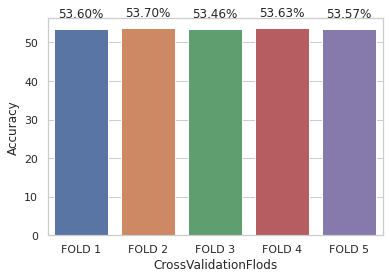

In [ ]:
sns.set_theme(style="whitegrid")
tips = pd.DataFrame(zip([f'FOLD {i+1}' for i in range(5)], np.array(scores)*100),
             columns = ['CrossValidationFlods', 'Accuracy'])
ax = sns.barplot(x="CrossValidationFlods", y="Accuracy", data=tips)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height),
            ha="center") 

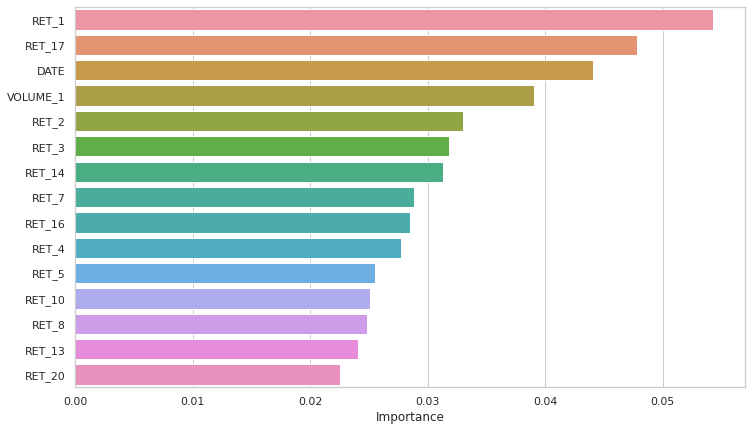

In [ ]:
feature_importances = pd.DataFrame([model.feature_importances_ for model in models], columns=clean_train.columns)
feature_importances = pd.DataFrame(feature_importances.mean(), columns= ['Importance'])
feature_importances = feature_importances.sort_values(by=['Importance'], ascending=False)

plt.figure(figsize=(12,7))
sns.set_theme(style="whitegrid")
sns.barplot(data=feature_importances.iloc[:15], y = feature_importances.index[:15], x= 'Importance');

## Feature Engineering

The main drawback in this challenge would be to deal with the noise. To do that, we could create some feature that aggregate features with some statistics. 

The following cell computes statistics on a given target conditionally to some features. For example, we want to generate a feature that describe the mean of `RET_1` conditionally to the `SECTOR` and the `DATE`.

**Ideas of improvement**: change shifts, the conditional features, the statistics, and the target. 

In [ ]:
# Feature engineering
new_features = []

# Conditional aggregated features
shifts = [1,2,3,4,5]  # Choose some different shifts
statistics = ['mean','std']  # the type of stat
gb_features = ['SECTOR', 'DATE']
target_feature = 'RET'
tmp_name = '_'.join(gb_features)
for shift in shifts:
    for stat in statistics:
        name = f'{target_feature}_{shift}_{tmp_name}_{stat}'
        feat = f'{target_feature}_{shift}'
        new_features.append(name)
        for data in [train, test]:
            data[name] = data.groupby(gb_features)[feat].transform(stat)

In [ ]:
train.describe()

,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,VOLUME_2,RET_3,VOLUME_3,RET_4,VOLUME_4,RET_5,VOLUME_5,RET_6,VOLUME_6,RET_7,VOLUME_7,RET_8,VOLUME_8,RET_9,VOLUME_9,RET_10,VOLUME_10,RET_11,VOLUME_11,RET_12,VOLUME_12,RET_13,VOLUME_13,RET_14,VOLUME_14,RET_15,VOLUME_15,RET_16,VOLUME_16,RET_17,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20,RET_1_SECTOR_DATE_mean,RET_1_SECTOR_DATE_std,RET_2_SECTOR_DATE_mean,RET_2_SECTOR_DATE_std,RET_3_SECTOR_DATE_mean,RET_3_SECTOR_DATE_std,RET_4_SECTOR_DATE_mean,RET_4_SECTOR_DATE_std,RET_5_SECTOR_DATE_mean,RET_5_SECTOR_DATE_std
count,418595.000000,418595.000000,418595.000000,418595.000000,418595.000000,418595.000000,416236.000000,353570.000000,416130.000000,352209.000000,416088.000000,350776.000000,416051.000000,347598.000000,416011.000000,343902.000000,415998.000000,343881.000000,416010.000000,344742.000000,415972.000000,344697.000000,415913.000000,345297.000000,415903.000000,345290.000000,415634.000000,346570.000000,415409.000000,356072.000000,415235.000000,359587.000000,414182.000000,357666.000000,413605.000000,352222.000000,413315.000000,351333.000000,413294.000000,356281.000000,413288.000000,351009.000000,413282.000000,351266.000000,413254.000000,350738.000000,416396.000000,416388.000000,416396.000000,416388.000000,416396.000000,416388.000000,416396.000000,416388.000000,416396.000000,416388.000000
mean,108.659002,3373.567833,37.176020,12.697959,5.483845,90.391663,0.001383,-0.071502,0.000973,-0.075230,0.002153,-0.097235,-0.000679,-0.088976,0.000358,-0.092163,-0.000261,-0.100510,0.000330,-0.084714,0.000124,-0.087037,-0.000621,-0.090863,0.000005,-0.092151,-0.000781,-0.084261,0.000914,-0.080856,0.001349,-0.075401,0.002468,-0.072426,0.001846,-0.085919,0.001074,-0.076018,0.001642,-0.087854,0.001131,-0.076147,-0.000798,-0.076496,-0.000027,-0.076337,0.001382,0.024415,0.000973,0.023870,0.002151,0.023824,-0.000677,0.024140,0.000358,0.024436
std,61.891642,1533.157749,19.706505,7.231701,2.410113,47.491157,0.031311,3.038658,0.030987,2.635549,0.031332,2.490831,0.031224,1.730786,0.031886,1.848977,0.031311,1.689065,0.030966,1.839735,0.031707,1.595809,0.032899,1.857236,0.031689,1.653412,0.030733,1.659034,0.187321,2.279505,0.032356,2.099580,0.030380,2.317314,0.032575,2.309389,0.029538,2.185741,0.031914,2.094459,0.031435,2.423121,0.030738,2.229668,0.033347,2.721355,0.015492,0.012147,0.016531,0.010963,0.016643,0.011836,0.016057,0.011730,0.016674,0.012034
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.845324,-2.434414,-0.770751,-3.007262,-0.740406,-3.370420,-0.863554,-2.390423,-0.792839,-1.810006,-0.723077,-2.294692,-0.660297,-2.157253,-0.806159,-2.219663,-0.896307,-4.020258,-0.753419,-2.572906,-0.755627,-2.184149,-0.807084,-2.357872,-0.828125,-4.228308,-0.827586,-5.148646,-0.816000,-4.388973,-0.765478,-5.600056,-0.825014,-4.610393,-0.876157,-4.167784,-0.880000,-2.341887,-0.785714,-2.768928,-0.085105,0.005636,-0.080458,0.005030,-0.159678,0.005315,-0.093955,0.004916,-0.075290,0.004619
25%,56.000000,2478.000000,22.000000,6.000000,4.000000,49.000000,-0.010970,-0.555394,-0.011312,-0.540629,-0.009769,-0.534880,-0.012798,-0.524475,-0.012249,-0.543178,-0.012314,-0.549228,-0.011416,-0.542892,-0.012294,-0.549793,-0.013011,-0.568801,-0.012685,-0.561765,-0.013420,-0.553933,-0.012173,-0.558539,-0.010250,-0.553880,-0.009964,-0.558473,-0.010788,-0.549576,-0.010527,-0.533574,-0.011331,-0.552613,-0.010949,-0.539491,-0.012139,-0.527846,-0.011682,-0.542790,-0.006178,0.017021,-0.007187,0.016989,-0.004739,0.016699,-0.008653,0.016800,-0.008517,0.016962
50%,104.000000,3560.000000,43.000000,15.000000,6.000000,104.000000,0.000637,-0.282609,0.000401,-0.278437,0.000909,-0.278277,-0.000495,-0.275435,0.000000,-0.281238,0.000000,-0.288125,0.000000,-0.284789,-0.000169,-0.289772,0.000000,-0.298185,0.000000,-0.295750,-0.000579,-0.291193,0.000000,-0.291331,0.001139,-0.292227,0.001055,-0.293028,0.000788,-0.282044,0.000530,-0.272271,0.000433,-0.285480,0.000000,-0.281753,0.000000,-0.277674,0.0000

## Feature selection

To reduce the number of feature (and the noise) we only consider the 5 last days of `RET` and `VOLUME` in addition to the newly created feature.

In [ ]:
target = 'RET'

n_shifts = 5  # If you don't want all the shifts to reduce noise
features = ['RET_%d' % (i + 1) for i in range(n_shifts)]
features += ['VOLUME_%d' % (i + 1) for i in range(n_shifts)]
features += new_features  # The conditional features
train[features].head()

,RET_1,RET_2,RET_3,RET_4,RET_5,VOLUME_1,VOLUME_2,VOLUME_3,VOLUME_4,VOLUME_5,RET_1_SECTOR_DATE_mean,RET_1_SECTOR_DATE_std,RET_2_SECTOR_DATE_mean,RET_2_SECTOR_DATE_std,RET_3_SECTOR_DATE_mean,RET_3_SECTOR_DATE_std,RET_4_SECTOR_DATE_mean,RET_4_SECTOR_DATE_std,RET_5_SECTOR_DATE_mean,RET_5_SECTOR_DATE_std
ID,,,,,,,,,,,,,,,,,,,,
0,-0.015748,-0.015504,0.010972,-0.014672,0.016483,0.147931,0.179183,0.033832,-0.362868,-0.972920,0.009178,0.024243,-0.017313,0.027124,-0.000148,0.023017,-0.000655,0.022291,0.005187,0.020780
1,0.003984,-0.090580,0.018826,-0.025540,-0.038062,NaN,NaN,NaN,NaN,NaN,0.006477,0.034339,-0.023300,0.041152,-0.008673,0.027523,-0.003666,0.024645,0.005630,0.032542
2,0.000440,-0.058896,-0.009042,0.024852,0.009354,-0.096282,0.084771,-0.298777,-0.157421,0.091455,0.013449,0.038375,-0.045074,0.043161,-0.011731,0.034345,-0.000976,0.033411,0.023137,0.037679
3,0.031298,0.007756,-0.004632,-0.019677,0.003544,-0.429540,-0.089919,-0.639737,-0.940163,-0.882464,0.017253,0.022464,0.001304,0.020111,-0.014219,0.020521,-0.009237,0.016483,-0.009513,0.016977
4,0.027273,-0.039302,0.000000,0.000000,0.022321,-0.847155,-0.943033,-1.180629,-1.313896,-1.204398,0.006241,0.022162,-0.014918,0.025569,-0.004146,0.035213,-0.000578,0.016154,0.001533,0.021997


## Model and local score

A Random Forest (RF) model is chosen. We consider a large number of tree with a quiet small depth. The missing values are simply filled with 0. A KFold is done on the dates (using `DATE`) for a local scoring of the model. 

**Ideas of improvements**: Tune the RF hyperparameters, deal with the missing values, change the features, consider another model, ...

In [ ]:
X_train = train[features]
y_train = train[target]

# A quiet large number of trees with low depth to prevent overfits
rf_params = {
    'n_estimators': 500,
    'max_depth': 2**3,
    'random_state': 0,
    'n_jobs': -1
}

train_dates = train['DATE'].unique()
test_dates = test['DATE'].unique()

n_splits = 4
scores = []
models = []

splits = KFold(n_splits=n_splits, random_state=0,
               shuffle=True).split(train_dates)

for i, (local_train_dates_ids, local_test_dates_ids) in enumerate(splits):
    local_train_dates = train_dates[local_train_dates_ids]
    local_test_dates = train_dates[local_test_dates_ids]

    local_train_ids = train['DATE'].isin(local_train_dates)
    local_test_ids = train['DATE'].isin(local_test_dates)

    X_local_train = X_train.loc[local_train_ids]
    y_local_train = y_train.loc[local_train_ids]
    X_local_test = X_train.loc[local_test_ids]
    y_local_test = y_train.loc[local_test_ids]

    X_local_train = X_local_train.fillna(0)
    X_local_test = X_local_test.fillna(0)

    model = RandomForestClassifier(**rf_params)
    model.fit(X_local_train, y_local_train)

    y_local_pred = model.predict_proba(X_local_test)[:, 1]
    
    sub = train.loc[local_test_ids].copy()
    sub['pred'] = y_local_pred
    y_local_pred = sub.groupby('DATE')['pred'].transform(lambda x: x > x.median()).values

    models.append(model)
    score = accuracy_score(y_local_test, y_local_pred)
    scores.append(score)
    print(f"Fold {i+1} - Accuracy: {score* 100:.2f}%")

mean = np.mean(scores)*100
std = np.std(scores)*100
u = (mean + std)
l = (mean - std)
print(f'Accuracy: {mean:.2f}% [{l:.2f} ; {u:.2f}] (+- {std:.2f})')

Fold 1 - Accuracy: 51.24%
Fold 2 - Accuracy: 50.05%
Fold 3 - Accuracy: 51.35%
Fold 4 - Accuracy: 51.17%
Accuracy: 50.95% [50.43 ; 51.48] (+- 0.53)


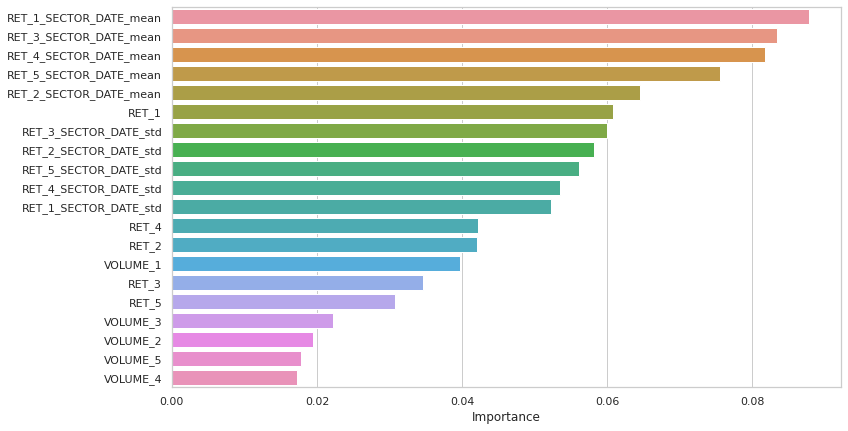

In [ ]:
feature_importances = pd.DataFrame([model.feature_importances_ for model in models], columns=features)
feature_importances = pd.DataFrame(feature_importances.mean(), columns= ['Importance'])
feature_importances = feature_importances.sort_values(by=['Importance'], ascending=False)

plt.figure(figsize=(12,7))
sns.set_theme(style="whitegrid")
sns.barplot(data=feature_importances, y = feature_importances.index, x= 'Importance');

## Generate the submission

The same parameters of the RF model are considered. With that we build a new RF model on the entire `train` dataset. The predictions are saved in a `.csv` file.

In [ ]:
X_test = test[features]

rf_params['random_state'] = 0
model = RandomForestClassifier(**rf_params)
model.fit(X_train.fillna(0), y_train)
y_pred = model.predict_proba(X_test.fillna(0))[:, 1]

sub = test.copy()
sub['pred'] = y_pred
y_pred = sub.groupby('DATE')['pred'].transform(
    lambda x: x > x.median()).values

submission = pd.Series(y_pred)
submission.index = test.index
submission.name = target

submission.to_csv('benchmark_qrt.csv', index=True, header=True)


The local accuracy is around 51. If we did not overfit, we shall expect something within the range above.

After submitting file, we obtain a public score of 51.31 %.

# Improvements in RF Classifier

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/challenge Stock prediction/x_train.csv', index_col='ID')
y_train = pd.read_csv('/content/drive/MyDrive/challenge Stock prediction/y_train.csv', index_col='ID')
test = pd.read_csv('/content/drive/MyDrive/challenge Stock prediction/x_test.csv', index_col='ID')

## Feature Engineering

We are going to add some other features to improve the model. We will then use some features generated with both Rolling window methon and Expanding Window method.

In [ ]:
train.fillna(value=0, inplace=True)
test.fillna(value=0, inplace=True)

In [ ]:
# Feature engineering
new_features = []

# Conditional aggregated features
shifts = [1,2,3,4,5]  # Choose some different shifts
statistics = ['mean','std']  # the type of stat
gb_features = ['SECTOR', 'DATE']
target_feature = 'RET'
tmp_name = '_'.join(gb_features)
for shift in shifts:
    for stat in statistics:
        name = f'{target_feature}_{shift}_{tmp_name}_{stat}'
        feat = f'{target_feature}_{shift}'
        new_features.append(name)
        for data in [train, test]:
            data[name] = data.groupby(gb_features)[feat].transform(stat)

In [ ]:
# Rolling window
def rolling(data , window_size = 5):
  features_to_roll = ['RET', 'VOLUME']
  rolling_features = []
  df = data.copy()
  for fr in features_to_roll:
    c = []
    for i in range(20):
      c.append(fr+f'_{20-i}')
    to_rol = data[c].copy()
    to_rol = to_rol.rolling(window_size,axis=1).mean().dropna(axis=1, how='any')
    c = []
    for i in range(len(to_rol.columns)):
      c.append(fr+'_rolling'+str(i+1))
    to_rol.columns = c
    rolling_features += list(to_rol.columns)
    df = pd.concat([df, to_rol], axis=1)
  return rolling_features, df

In [ ]:
rol_features, train = rolling(train , window_size = 5)
_ , test = rolling(test , window_size = 5)
new_features += rol_features

In [ ]:
# Expanding Window Feature
def expanding_fc(data):
  features_to_roll = ['RET', 'VOLUME']
  exp_features = []
  df = data.copy()
  for fr in features_to_roll:
    c = []
    for i in range(20):
      c.append(fr+f'_{20-i}')
    to_rol = data[c].copy()
    to_rol = to_rol.expanding(axis=1).mean().dropna(axis=1, how='any')
    c = []
    for i in range(len(to_rol.columns)):
      c.append(fr+'_expanding'+str(i+1))
    to_rol.columns = c
    exp_features += list(to_rol.columns)
    df = pd.concat([df, to_rol], axis=1)
  return exp_features, df


In [ ]:
exp_features, train = expanding_fc(train)
_ , test = expanding_fc(test)
new_features += exp_features

## Momentum
The momentum indicator compares the current price with the price in the past to get the relation of current price with the past price.
The momentum indicator is simply a difference of the current price and a past price.
Momentum(t) = C(t) − Ck(t)
Where, k is number of days to look in past.


In [ ]:
def Momentum(Data):
  X=Data.drop(columns=['DATE','STOCK','INDUSTRY','INDUSTRY_GROUP','SECTOR','SUB_INDUSTRY'])
  X_RET=X
  for k in range(1,21):
    X_RET=X_RET.drop(columns='VOLUME_' + str(k))
  Moment=pd.DataFrame(index=Data.index)
  for i in range(1,6):
    Moment['Momentum_'+ str(i)]=X_RET['RET_'+ str(i)]-X_RET['RET_'+ str(i+10)]
  return Moment

In [ ]:
train=pd.concat([train,Momentum(x_train)],axis=1)
test=pd.concat([test,Momentum(x_test)],axis=1)

## Feature selection

To reduce the number of feature (and the noise) we will use the PCA algorithm, an algorithm for dimension reduction.

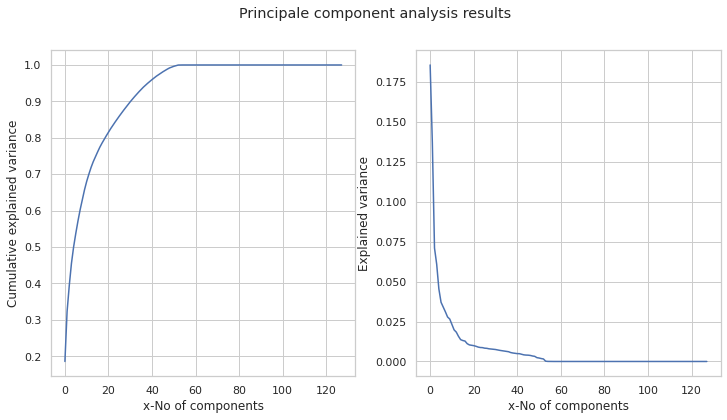

In [ ]:
# Standarization
from sklearn.preprocessing import StandardScaler
train.fillna(value=0, inplace=True)
sc = StandardScaler()
X_train_std = sc.fit_transform(train)

# PCA
from sklearn.decomposition import PCA
pca = PCA().fit(X_train_std)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize= (12,6))
fig.suptitle('Principale component analysis results')
ax1.plot(np.cumsum(pca.explained_variance_ratio_))
ax1.set(xlabel='x-No of components', ylabel='Cumulative explained variance')
ax2.plot(pca.explained_variance_ratio_)
ax2.set(xlabel='x-No of components', ylabel='Explained variance')
plt.show()

In [ ]:
pca = PCA(n_components = 50)
pcs = pca.fit_transform(X_train_std)
cols_pca=['PC'+str(i) for i in range(1,51)]
X_train_pca = pd.DataFrame(data=pcs, columns=cols_pca)
X_train_pca.head(3)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50
0,4.018002,4.698753,-5.149990,-0.990862,0.603508,-1.309967,3.468194,-3.440470,-4.660785,-2.411114,1.825354,0.291618,1.637892,-2.476804,-1.664613,0.753167,-3.504218,-0.284177,-1.574178,3.280496,0.497321,-2.433531,2.359515,3.457336,0.895933,2.187235,2.216859,-1.479359,-1.220202,2.859434,-1.346340,-1.146964,1.595053,-0.797473,0.109692,0.495636,1.301519,0.173220,0.245586,0.822855,0.740039,-0.976880,0.268127,0.201964,0.373080,-0.009521,-0.244317,0.231661,-0.368046,0.256842
1,-0.464808,-1.673479,-2.105213,3.278928,-0.002743,0.183280,1.744044,-0.262239,-1.972862,-4.430184,3.844512,-1.661711,2.330004,-0.507926,-0.393869,1.607296,0.383697,-1.813065,0.329177,1.400788,0.583211,-1.687840,1.323714,1.379462,-1.164427,1.402270,1.676976,-1.036276,-2.524255,0.854109,-1.977049,-0.837731,1.470882,-0.158271,0.610307,-0.973320,-1.006332,-0.163135,0.307127,0.348719,0.351130,0.775372,-0.552614,0.254317,-0.130463,-0.180872,1.448500,0.481564,0.036499,-0.079766
2,-1.294641,-0.177396,-0.892460,1.978464,0.068496,-0.173156,-0.692524,1.885993,-1.317139,0.547879,2.467359,-0.246109,-0.064838,0.730030,-0.967997,0.535120,0.245673,-1.324476,0.458818,-0.477900,0.517541,-0.660216,0.985672,3.350065,0.642426,-0.233749,0.189010,-0.020384,-1.243694,1.583200,-1.468874,-0.574378,1.150387,0.266893,0.034434,0.113107,-0.271565,-0.063806,-0.049140,-0.086013,-0.227303,-0.479480,0.151411,-0.211987,0.222566,-0.075990,1.057040,-0.235375,-1.015049,0.225588


In [ ]:
# Applied PCA transformation to test data
test.fillna(value=0, inplace=True)
X_test_std = sc.fit_transform(test)
pcs = pca.transform(X_test_std)
cols_pca=['PC'+str(i) for i in range(1,51)]
X_test_pca = pd.DataFrame(data=pcs, columns=cols_pca)
X_test_pca.head(3)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50
0,0.097353,1.056422,0.931231,-1.616561,0.159333,0.014903,0.272070,-0.001453,0.516679,0.253193,-0.784930,0.490435,-0.481720,-0.090355,0.328743,0.886311,0.013863,0.373147,0.218819,-0.244807,0.071071,-0.596443,-0.055990,0.814312,-0.049656,0.689800,-0.473505,0.922212,-1.033747,0.952598,-0.470767,-0.473910,0.139687,-0.926874,0.282948,0.350000,0.033576,-0.001515,0.036414,-0.084008,0.028515,-0.154003,-0.034535,-0.504272,-0.426537,0.006998,0.050167,0.349810,0.512107,0.428007
1,-0.082325,1.728541,0.522517,0.812242,-1.271473,0.206446,0.824170,-2.235647,0.475126,-0.353912,-0.904544,0.010571,1.030921,-0.542143,0.030844,0.939464,0.404051,0.873181,0.222711,-0.654608,-0.291513,-1.340138,-0.137733,0.305191,0.109606,1.384768,-0.940703,0.398277,-1.109821,1.056858,-0.395203,-0.535847,0.639356,-0.360343,0.287965,0.237735,0.018194,0.245405,0.086342,0.439519,-0.123478,0.093922,0.386630,-0.678660,-0.183120,0.161853,-0.187179,0.754869,0.309660,0.666393
2,0.346222,-0.497393,-0.625297,-1.355223,-0.513317,2.000777,1.291575,2.010345,0.419114,-1.602760,-0.377584,-0.976239,0.995608,-0.313803,0.563836,0.243511,1.176378,0.618210,0.093978,-1.164456,-0.290192,-1.345171,0.920177,0.192306,0.683110,0.264335,-1.178437,0.657798,-0.979675,0.743203,0.251295,-0.830162,0.267811,-1.202699,0.758120,0.831221,0.295379,0.402306,0.060170,-0.113362,0.418982,0.554979,0.353894,-1.114585,-0.182872,-0.057871,1.570696,0.094351,0.690290,0.066627


## Model and local score

Again a Random Forest (RF) model is chosen. We consider a large number of tree with a quiet small depth. The missing values are simply filled with 0. A KFold is done on the dates (using `DATE`) for a local scoring of the model. 

In [ ]:
# A quiet large number of trees with low depth to prevent overfits
rf_params = {
    'n_estimators': 500,
    'max_depth': 2**3,
    'random_state': 0,
    'n_jobs': -1
}

n_splits = 5
scores = []
models = []

splits = KFold(n_splits=n_splits, random_state=0, shuffle=True).split(X_train_pca)

for i, (train_ids, test_ids) in enumerate(splits):
    local_train = X_train_pca.iloc[train_ids]
    local_test = X_train_pca.iloc[test_ids]

    y_local_train = y_train.loc[train_ids].RET.values
    y_local_test = y_train.loc[test_ids].RET.values

    model = RandomForestClassifier(**rf_params)
    model.fit(local_train, y_local_train)

    y_local_pred = model.predict_proba(local_test)[:, 1]
    y_local_pred = y_local_pred > np.median(y_local_pred)

    models.append(model)
    score = accuracy_score(y_local_test, y_local_pred)
    scores.append(score)
    print(f"Fold {i+1} - Accuracy: {score* 100:.2f}%")

mean = np.mean(scores)*100
std = np.std(scores)*100
u = (mean + std)
l = (mean - std)
print(f'Accuracy: {mean:.2f}% [{l:.2f} ; {u:.2f}] (+- {std:.2f})')

Fold 1 - Accuracy: 53.59%
Fold 2 - Accuracy: 54.02%
Fold 3 - Accuracy: 53.61%
Fold 4 - Accuracy: 53.76%
Fold 5 - Accuracy: 53.74%
Accuracy: 53.75% [53.59 ; 53.90] (+- 0.15)


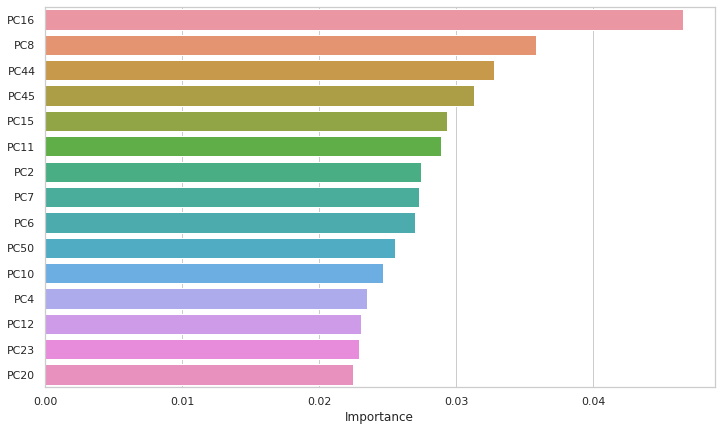

In [ ]:
feature_importances = pd.DataFrame([model.feature_importances_ for model in models], columns=X_train_pca.columns)
feature_importances = pd.DataFrame(feature_importances.mean(), columns= ['Importance'])
feature_importances = feature_importances.sort_values(by=['Importance'], ascending=False)

plt.figure(figsize=(12,7))
sns.set_theme(style="whitegrid")
sns.barplot(data=feature_importances.iloc[:15], y = feature_importances.index[:15], x= 'Importance');

## Generate the submission

The same parameters of the RF model are considered. With that we build a new RF model on the entire `train` dataset. The predictions are saved in a `.csv` file.

In [ ]:
model = RandomForestClassifier(**rf_params)
model.fit(X_train_pca, y_train.RET.values)
y_pred = model.predict_proba(X_test_pca)[:, 1]
y_pred = y_pred > np.median(y_pred)

In [ ]:
submission = pd.Series(y_pred)
submission.index = test.index
submission.name = 'RET'
submission.to_csv('submission2.csv', index=True, header=True)

# Boosting Classifiers

## First Model

We are going to build a first xg-boost model using the same dataset with all the feature engineering traited in the last section.

In [ ]:
import xgboost as xgb

param = {'max_depth': 3, 'eta': 1, 'objective': 'binary:logistic',
         'n_estimators':10000, 'nthread' : 4, 'eval_metric' : 'auc'}

train_x, valid_x, train_y, valid_y = train_test_split(X_train_pca, y_train.RET.values, shuffle=True, train_size=0.8)

# Matrix design
dtrain = xgb.DMatrix(train_x, label=np.array(train_y, dtype=int))
dvalid = xgb.DMatrix(valid_x, label=np.array(valid_y, dtype=int))
evallist = [(dvalid, 'eval'), (dtrain, 'train')]

# train the model
num_round = 500
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)

[0]	eval-auc:0.513319	train-auc:0.513003
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 10 rounds.
[1]	eval-auc:0.51909	train-auc:0.522975
[2]	eval-auc:0.521119	train-auc:0.527441
[3]	eval-auc:0.525564	train-auc:0.532689
[4]	eval-auc:0.528636	train-auc:0.536464
[5]	eval-auc:0.529245	train-auc:0.538808
[6]	eval-auc:0.531652	train-auc:0.541024
[7]	eval-auc:0.532819	train-auc:0.543892
[8]	eval-auc:0.533544	train-auc:0.54618
[9]	eval-auc:0.535753	train-auc:0.548002
[10]	eval-auc:0.536505	train-auc:0.548828
[11]	eval-auc:0.537593	train-auc:0.550038
[12]	eval-auc:0.537619	train-auc:0.551127
[13]	eval-auc:0.53983	train-auc:0.553184
[14]	eval-auc:0.53968	train-auc:0.554372
[15]	eval-auc:0.539824	train-auc:0.555423
[16]	eval-auc:0.539921	train-auc:0.556003
[17]	eval-auc:0.540107	train-auc:0.556508
[18]	eval-auc:0.54104	train-auc:0.557203
[19]	eval-auc:0.541516	train-auc:0.558176
[20]	eval-auc:0.542022	train-auc

In [ ]:
y_pred = bst.predict(dvalid, ntree_limit=bst.best_ntree_limit)
y_pred = y_pred > 0.5
acc = accuracy_score(valid_y, y_pred) * 100
print(f'Accuracy in validation Set: {acc:.2f} % ')

Accuracy in validation Set: 54.75 % 


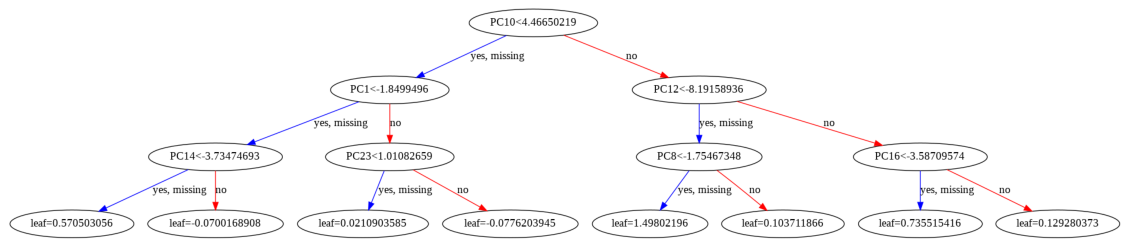

In [ ]:
# An example of constructed tree
fig, ax = plt.subplots(1, 1,figsize= (20,12))
xgb.plot_tree(bst, num_trees=2, ax = ax)
plt.show()

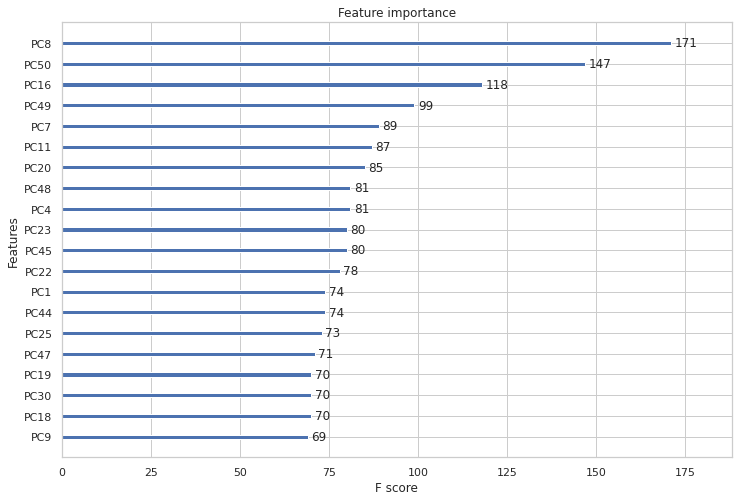

In [ ]:
# Importance
fig, ax = plt.subplots(1, 1,figsize= (12,8))
xgb.plot_importance(bst, ax=ax, max_num_features= 20)
plt.show()

In [ ]:
dtest = xgb.DMatrix(X_test_pca)
y_pred = bst.predict(dtest)
y_pred = y_pred > 0.5
submission = pd.Series(y_pred)
submission.index = test.index
submission.name = 'RET'
submission.to_csv('submission.csv', index=True, header=True)

## Feature Engineering / Modeling

In [ ]:
# drop rolling and expanding features and try the Moving average
c = []
for i in range(20):
  c.append(f'VOLUME_expanding{i+1}')
  new_features.remove(f'VOLUME_expanding{i+1}')
  c.append(f'RET_expanding{i+1}')
  new_features.remove(f'RET_expanding{i+1}')
train.drop(columns = c, inplace= True)
test.drop(columns = c, inplace= True)

c = []
for i in range(16):
  c.append(f'VOLUME_rolling{i+1}')
  new_features.remove(f'VOLUME_rolling{i+1}')
  c.append(f'RET_rolling{i+1}')
  new_features.remove(f'RET_rolling{i+1}')
train.drop(columns = c, inplace= True)
test.drop(columns = c, inplace= True)

print(new_features)

['RET_1_SECTOR_DATE_mean', 'RET_1_SECTOR_DATE_std', 'RET_2_SECTOR_DATE_mean', 'RET_2_SECTOR_DATE_std', 'RET_3_SECTOR_DATE_mean', 'RET_3_SECTOR_DATE_std', 'RET_4_SECTOR_DATE_mean', 'RET_4_SECTOR_DATE_std', 'RET_5_SECTOR_DATE_mean', 'RET_5_SECTOR_DATE_std']


In [ ]:
# Exponential Moving Average
def ema(data , sp = 20):
  features_to_emv = ['RET', 'VOLUME']
  ema_features = []
  df = data.copy()
  for fr in features_to_emv:
    c = []
    for i in range(20):
      c.append(fr+f'_{20-i}')
    to_rol = data[c].copy()
    to_rol = to_rol.ewm(span=sp, adjust=False).mean()
    c = []
    for i in range(len(to_rol.columns)):
      c.append(fr+'_ema'+str(i+1))
    to_rol.columns = c
    ema_features += list(to_rol.columns)
    df = pd.concat([df, to_rol], axis=1)
  return ema_features, df

In [ ]:
ema_features, train = ema(train , sp = 20)
_ , test = ema(test , sp = 20)
new_features += ema_features

In [ ]:
# Keep just RET and VOLUME from last 5 days to avoid noise
n_shifts = 5 
features = ['RET_%d' % (i + 1) for i in range(n_shifts)]
features += ['VOLUME_%d' % (i + 1) for i in range(n_shifts)]
features += new_features  # The conditional features
train = train[features]
test = test[features]

In [ ]:
import xgboost as xgb

param = {'max_depth': 4, 'eta': 1, 'objective': 'binary:logistic',
         'n_estimators':1000, 'nthread' : 4, 'eval_metric' : 'auc'}

train_x, valid_x, train_y, valid_y = train_test_split(train, y_train.RET.values, shuffle=True, train_size=0.8)

# Matrix design
dtrain = xgb.DMatrix(train_x, label=np.array(train_y, dtype=int))
dvalid = xgb.DMatrix(valid_x, label=np.array(valid_y, dtype=int))
evallist = [(dtrain, 'train'), (dvalid, 'eval')]

# train the model
num_round = 500
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)

[0]	train-auc:0.521481	eval-auc:0.5202
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[1]	train-auc:0.536557	eval-auc:0.532806
[2]	train-auc:0.545229	eval-auc:0.541914
[3]	train-auc:0.55506	eval-auc:0.549109
[4]	train-auc:0.561448	eval-auc:0.553527
[5]	train-auc:0.568807	eval-auc:0.560571
[6]	train-auc:0.572635	eval-auc:0.5642
[7]	train-auc:0.577176	eval-auc:0.568345
[8]	train-auc:0.581327	eval-auc:0.57102
[9]	train-auc:0.584274	eval-auc:0.573425
[10]	train-auc:0.586718	eval-auc:0.576149
[11]	train-auc:0.58918	eval-auc:0.577762
[12]	train-auc:0.592336	eval-auc:0.580394
[13]	train-auc:0.594877	eval-auc:0.581409
[14]	train-auc:0.597792	eval-auc:0.583403
[15]	train-auc:0.599377	eval-auc:0.584235
[16]	train-auc:0.600951	eval-auc:0.585769
[17]	train-auc:0.603549	eval-auc:0.586748
[18]	train-auc:0.606609	eval-auc:0.589871
[19]	train-auc:0.608462	eval-auc:0.591355
[20]	train-auc:0.609604	eval-auc:0.5

In [ ]:
y_pred = bst.predict(dvalid, ntree_limit=bst.best_ntree_limit)
y_pred = y_pred > 0.5
acc = accuracy_score(valid_y, y_pred) * 100
print(f'Accuracy in validation Set: {acc:.2f} % ')

Accuracy in validation Set: 57.78 % 


In [ ]:
print(classification_report(valid_y, y_pred))

              precision    recall  f1-score   support

       False       0.58      0.58      0.58     41959
        True       0.58      0.58      0.58     41760

    accuracy                           0.58     83719
   macro avg       0.58      0.58      0.58     83719
weighted avg       0.58      0.58      0.58     83719



In [ ]:
print(confusion_matrix(valid_y, y_pred))

[[24258 17701]
 [17646 24114]]


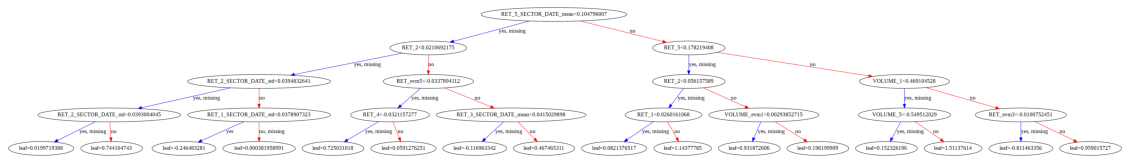

In [ ]:
# An example of constructed tree
fig, ax = plt.subplots(1, 1,figsize= (20,20))
xgb.plot_tree(bst, num_trees=2, ax = ax)
plt.show()

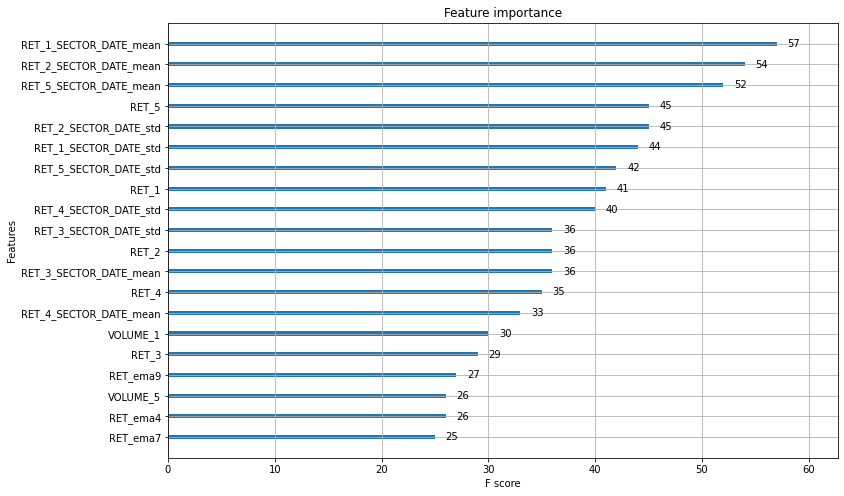

In [ ]:
# Importance
fig, ax = plt.subplots(1, 1,figsize= (12,8))
xgb.plot_importance(bst, ax=ax, max_num_features= 20)
plt.show()

In [ ]:
dtest = xgb.DMatrix(test)
y_pred = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)
y_pred = y_pred > 0.5
submission = pd.Series(y_pred)
submission.index = test.index
submission.name = 'RET'
submission.to_csv('submission.csv', index=True, header=True)

Let's try to use some Technical Analysis Indicators. In the world of finance, one of the more famous ones is the **Moving Average Convergence Divergence indicator**, or **MACD** for short. It is basically the difference between two exponential moving averages, more precisely :

***MACD = 12_Period EMA − 26_Period EMA***

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/challenge Stock prediction/x_train.csv', index_col='ID')
test = pd.read_csv('/content/drive/MyDrive/challenge Stock prediction/x_test.csv', index_col='ID')
train.fillna(value=0, inplace=True)
test.fillna(value=0, inplace=True)

In [ ]:
# Feature engineering
new_features = []
def aggregated(target_feature,  gb_features, shifts, statistics):
  # Conditional aggregated features
  tmp_name = '_'.join(gb_features)
  for shift in shifts:
      for stat in statistics:
          name = f'{target_feature}_{shift}_{tmp_name}_{stat}'
          feat = f'{target_feature}_{shift}'
          new_features.append(name)
          for data in [train, test]:
              data[name] = data.groupby(gb_features)[feat].transform(stat)

In [ ]:
gb_features = ['SECTOR', 'DATE']
shifts = [1,2,3,4,5]  # Choose some different shifts
statistics = ['mean','std']
target_features = ['RET', 'VOLUME']
for trgt in target_features :
  aggregated(target_feature = trgt, gb_features=gb_features, 
             shifts=shifts, statistics=statistics)

In [ ]:
# Moving Average Convergence Divergence (MACD)
def macd(data):
  features_to_emv = ['RET', 'VOLUME']
  emv_features = []
  df = data.copy()
  for fr in features_to_emv:
    c = []
    for i in range(20):
      c.append(fr+f'_{20-i}')
    to_rol = data[c].copy()
    to_rol1 = to_rol.ewm(span=12, adjust=False).mean()
    to_rol2 = to_rol.ewm(span=26, adjust=False).mean()
    to_rol = to_rol1 - to_rol2
    to_rol3 = to_rol.ewm(span=9, adjust=False).mean()
    c = []
    for i in range(len(to_rol.columns)):
      c.append(fr+'_masd'+str(i+1))
    to_rol.columns = c
    c = []
    for i in range(len(to_rol3.columns)):
      c.append(fr+'_signal_line'+str(i+1))
    to_rol3.columns = c
    emv_features += list(to_rol.columns)
    emv_features += list(to_rol3.columns)
    df = pd.concat([df, to_rol], axis=1)
    df = pd.concat([df, to_rol3], axis=1)
  return emv_features, df

In [ ]:
emv_features, train = macd(train)
_ , test = macd(test)
new_features += emv_features

In [ ]:
# Keep just RET and VOLUME from last 5 days to avoid noise
n_shifts = 5 
features = ['RET_%d' % (i + 1) for i in range(n_shifts)]
features += ['VOLUME_%d' % (i + 1) for i in range(n_shifts)]
features += new_features  # The conditional features
features += ['DATE', 'STOCK', 'INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR', 'SUB_INDUSTRY']
train = train[features]
test = test[features]

In [ ]:
import xgboost as xgb

param = {'max_depth': 4, 'eta': 1, 'objective': 'binary:logistic',
         'n_estimators':1000, 'nthread' : 4, 'eval_metric' : 'auc'}

train_x, valid_x, train_y, valid_y = train_test_split(train, y_train.RET.values, shuffle=True, train_size=0.8)

# Matrix design
dtrain = xgb.DMatrix(train_x, label=np.array(train_y, dtype=int))
dvalid = xgb.DMatrix(valid_x, label=np.array(valid_y, dtype=int))
evallist = [(dtrain, 'train'), (dvalid, 'eval')]

# train the model
num_round = 500
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)

[0]	train-auc:0.520872	eval-auc:0.519972
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[1]	train-auc:0.530404	eval-auc:0.526559
[2]	train-auc:0.54141	eval-auc:0.536526
[3]	train-auc:0.553593	eval-auc:0.549367
[4]	train-auc:0.559572	eval-auc:0.55466
[5]	train-auc:0.565923	eval-auc:0.561578
[6]	train-auc:0.574093	eval-auc:0.569046
[7]	train-auc:0.576492	eval-auc:0.570648
[8]	train-auc:0.582059	eval-auc:0.574561
[9]	train-auc:0.584037	eval-auc:0.575306
[10]	train-auc:0.586425	eval-auc:0.576407
[11]	train-auc:0.59138	eval-auc:0.579538
[12]	train-auc:0.595749	eval-auc:0.583937
[13]	train-auc:0.599395	eval-auc:0.587617
[14]	train-auc:0.603776	eval-auc:0.591062
[15]	train-auc:0.60683	eval-auc:0.593352
[16]	train-auc:0.609455	eval-auc:0.59516
[17]	train-auc:0.612865	eval-auc:0.597837
[18]	train-auc:0.614562	eval-auc:0.598897
[19]	train-auc:0.616621	eval-auc:0.600965
[20]	train-auc:0.617725	eval-auc:0

In [ ]:
y_pred = bst.predict(dvalid, ntree_limit=bst.best_ntree_limit)
y_pred = y_pred > 0.5
acc = accuracy_score(valid_y, y_pred) * 100
print(f'Accuracy in validation Set: {acc:.2f} % ')

Accuracy in validation Set: 57.86 % 


In [ ]:
print('Classification report :\n' + classification_report(valid_y, y_pred))
print('Confusion Matrix :')
print(confusion_matrix(valid_y, y_pred))

Classification report :
              precision    recall  f1-score   support

       False       0.58      0.58      0.58     42329
        True       0.57      0.58      0.58     41390

    accuracy                           0.58     83719
   macro avg       0.58      0.58      0.58     83719
weighted avg       0.58      0.58      0.58     83719

Confusion Matrix :
[[24424 17905]
 [17371 24019]]


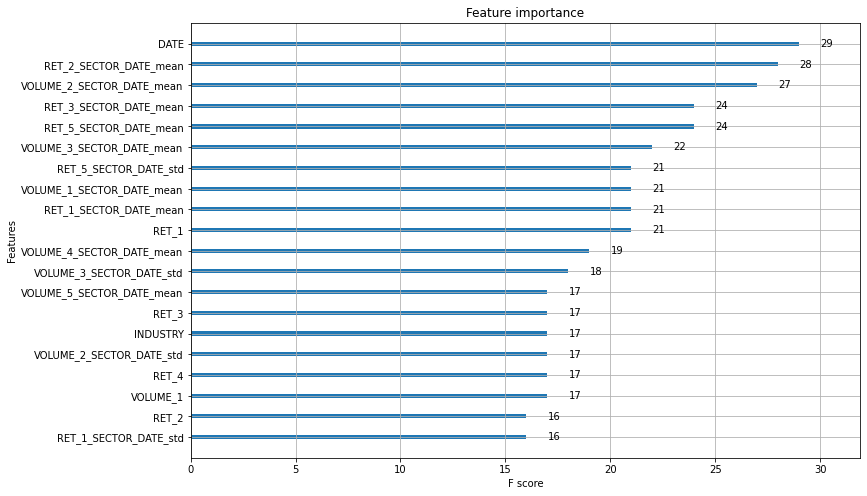

In [ ]:
# Importance
fig, ax = plt.subplots(1, 1,figsize= (12,8))
xgb.plot_importance(bst, ax=ax, max_num_features= 20)
plt.show()

In [ ]:
dtest = xgb.DMatrix(test)
y_pred = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)
y_pred = y_pred > 0.5
submission = pd.Series(y_pred)
submission.index = test.index
submission.name = 'RET'
submission.to_csv('submission.csv', index=True, header=True)

Let's try to build some new features based in aggregated conditionnally statistics. Since the DATE is one of the most important columns, we will group it with the other columns each separately to build conditional statistics.

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/challenge Stock prediction/x_train.csv', index_col='ID')
y_train = pd.read_csv('/content/drive/MyDrive/challenge Stock prediction/y_train.csv', index_col='ID')
test = pd.read_csv('/content/drive/MyDrive/challenge Stock prediction/x_test.csv', index_col='ID')

In [ ]:
train.fillna(value=0, inplace=True)
test.fillna(value=0, inplace=True)

In [ ]:
# Feature engineering
new_features = []
def aggregated(target_feature,  gb_features, shifts, statistics):
  # Conditional aggregated features
  tmp_name = '_'.join(gb_features)
  for shift in shifts:
      for stat in statistics:
          name = f'{target_feature}_{shift}_{tmp_name}_{stat}'
          feat = f'{target_feature}_{shift}'
          new_features.append(name)
          for data in [train, test]:
              data[name] = data.groupby(gb_features)[feat].transform(stat)

In [ ]:
# Feature engineering
new_features = []

# Conditional aggregated features
shifts = [1,2,3,4,5]  # Choose some different shifts
statistics = ['mean','std']  # the type of stat
gb_features_used = [['SECTOR', 'DATE'], ['INDUSTRY', 'DATE'], ['SUB_INDUSTRY', 'DATE'],
                ['INDUSTRY_GROUP', 'DATE'], ['STOCK', 'DATE']]

gb_features = ['SECTOR', 'DATE']
target_features = ['RET', 'VOLUME']
for trgt in target_features :
  for gb_features in gb_features_used :
    aggregated(target_feature = trgt, gb_features=gb_features, 
               shifts=shifts, statistics=statistics)

In [ ]:
# Keep just RET and VOLUME from last 5 days to avoid noise
n_shifts = 5 
features = ['RET_%d' % (i + 1) for i in range(n_shifts)]
features += ['VOLUME_%d' % (i + 1) for i in range(n_shifts)]
features += new_features  # The conditional features
features += ['DATE', 'STOCK', 'INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR', 'SUB_INDUSTRY']
train = train[features]
test = test[features]

In [ ]:
import xgboost as xgb

param = {'max_depth': 4, 'eta': 1, 'objective': 'binary:logistic',
         'n_estimators':1000, 'nthread' : 4, 'eval_metric' : 'auc'}

train_x, valid_x, train_y, valid_y = train_test_split(train, y_train.RET.values, shuffle=True, train_size=0.8)

# Matrix design
dtrain = xgb.DMatrix(train_x, label=np.array(train_y, dtype=int))
dvalid = xgb.DMatrix(valid_x, label=np.array(valid_y, dtype=int))
evallist = [(dtrain, 'train'), (dvalid, 'eval')]

# train the model
num_round = 500
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)

[0]	train-auc:0.52106	eval-auc:0.519323
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[1]	train-auc:0.527788	eval-auc:0.525252
[2]	train-auc:0.545917	eval-auc:0.543173
[3]	train-auc:0.554991	eval-auc:0.549766
[4]	train-auc:0.559025	eval-auc:0.553179
[5]	train-auc:0.563239	eval-auc:0.556904
[6]	train-auc:0.576209	eval-auc:0.568332
[7]	train-auc:0.583109	eval-auc:0.573541
[8]	train-auc:0.587504	eval-auc:0.576765
[9]	train-auc:0.591945	eval-auc:0.582301
[10]	train-auc:0.596414	eval-auc:0.587214
[11]	train-auc:0.599598	eval-auc:0.590109
[12]	train-auc:0.60359	eval-auc:0.593326
[13]	train-auc:0.60669	eval-auc:0.595399
[14]	train-auc:0.610286	eval-auc:0.599006
[15]	train-auc:0.61241	eval-auc:0.600144
[16]	train-auc:0.613876	eval-auc:0.600901
[17]	train-auc:0.61564	eval-auc:0.601915
[18]	train-auc:0.618574	eval-auc:0.604288
[19]	train-auc:0.620536	eval-auc:0.605997
[20]	train-auc:0.621983	eval-auc:0

In [ ]:
y_pred = bst.predict(dvalid, ntree_limit=bst.best_ntree_limit)
y_pred = y_pred > 0.5
acc = accuracy_score(valid_y, y_pred) * 100
print(f'Accuracy in validation Set: {acc:.2f} % ')

Accuracy in validation Set: 59.48 % 


In [ ]:
print('Classification report :\n' + classification_report(valid_y, y_pred))
print('Confusion Matrix :')
print(confusion_matrix(valid_y, y_pred))

Classification report :
              precision    recall  f1-score   support

       False       0.59      0.60      0.60     41963
        True       0.59      0.59      0.59     41756

    accuracy                           0.59     83719
   macro avg       0.59      0.59      0.59     83719
weighted avg       0.59      0.59      0.59     83719

Confusion Matrix :
[[25233 16730]
 [17194 24562]]


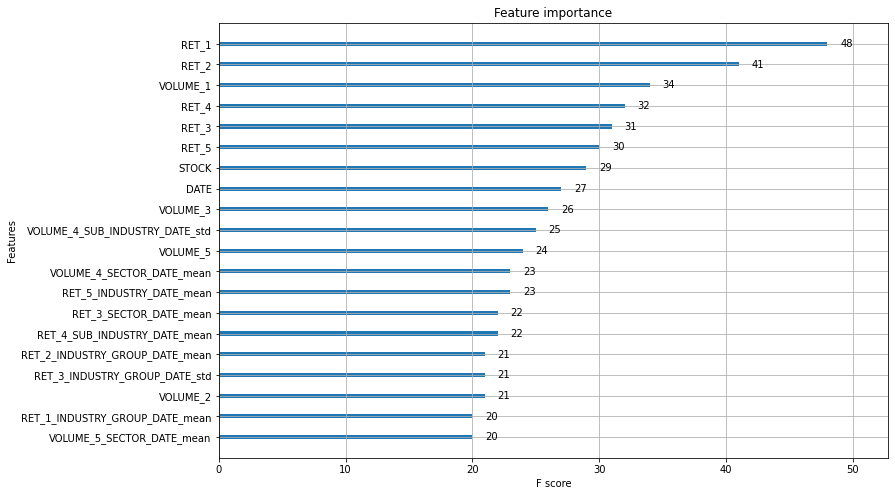

In [ ]:
# Importance
fig, ax = plt.subplots(1, 1,figsize= (12,8))
xgb.plot_importance(bst, ax=ax, max_num_features= 20)
plt.show()

In [ ]:
# Make a submission
dtest = xgb.DMatrix(test)
y_pred = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)
y_pred = y_pred > 0.5
submission = pd.Series(y_pred)
submission.index = test.index
submission.name = 'RET'
submission.to_csv('submission.csv', index=True, header=True)

## Cat-Boost Classifier

In [ ]:
!pip install catboost

     |████████████████████████████████| 66.3MB 44kB/s 


In [ ]:
from catboost import CatBoostClassifier, Pool, cv

CB_CF = CatBoostClassifier(iterations=1500, learning_rate=0.01, l2_leaf_reg=3.5,
                           depth=8, rsm=0.98, loss_function= 'Logloss',
                           eval_metric='Accuracy',use_best_model=True, 
                           random_seed=42, logging_level = 'Verbose',
                           od_type = 'Iter', od_wait = 40)

CB_CF.fit(train_x, train_y, eval_set = (valid_x, valid_y))

0:	learn: 0.5211451	test: 0.5179350	best: 0.5179350 (0)	total: 278ms	remaining: 6m 56s
1:	learn: 0.5266546	test: 0.5211601	best: 0.5211601 (1)	total: 566ms	remaining: 7m 4s
2:	learn: 0.5297812	test: 0.5261052	best: 0.5261052 (2)	total: 861ms	remaining: 7m 9s
3:	learn: 0.5347323	test: 0.5309309	best: 0.5309309 (3)	total: 1.13s	remaining: 7m 4s
4:	learn: 0.5362104	test: 0.5325434	best: 0.5325434 (4)	total: 1.41s	remaining: 7m 2s
5:	learn: 0.5372108	test: 0.5329734	best: 0.5329734 (5)	total: 1.69s	remaining: 7m 1s
6:	learn: 0.5405254	test: 0.5358879	best: 0.5358879 (6)	total: 1.96s	remaining: 6m 58s
7:	learn: 0.5403761	test: 0.5364374	best: 0.5364374 (7)	total: 2.23s	remaining: 6m 56s
8:	learn: 0.5406120	test: 0.5370107	best: 0.5370107 (8)	total: 2.54s	remaining: 7m
9:	learn: 0.5436042	test: 0.5401044	best: 0.5401044 (9)	total: 2.8s	remaining: 6m 57s
10:	learn: 0.5443866	test: 0.5403911	best: 0.5403911 (10)	total: 3.08s	remaining: 6m 57s
11:	learn: 0.5478117	test: 0.5445717	best: 0.544571

In [ ]:
y_pred = CB_CF.predict(valid_x)=='True'
acc = accuracy_score(valid_y, y_pred) * 100
print(f'Accuracy in validation Set: {acc:.2f} % ')

Accuracy in validation Set: 59.92 % 


In [ ]:
print('Classification report :\n' + classification_report(valid_y, y_pred))
print('Confusion Matrix :')
print(confusion_matrix(valid_y, y_pred))

Classification report :
              precision    recall  f1-score   support

       False       0.60      0.61      0.60     41838
        True       0.60      0.59      0.60     41881

    accuracy                           0.60     83719
   macro avg       0.60      0.60      0.60     83719
weighted avg       0.60      0.60      0.60     83719

Confusion Matrix :
[[25352 16486]
 [17067 24814]]


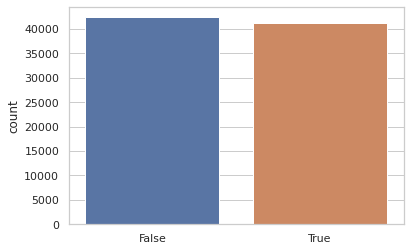

In [ ]:
sns.countplot(x = y_pred);

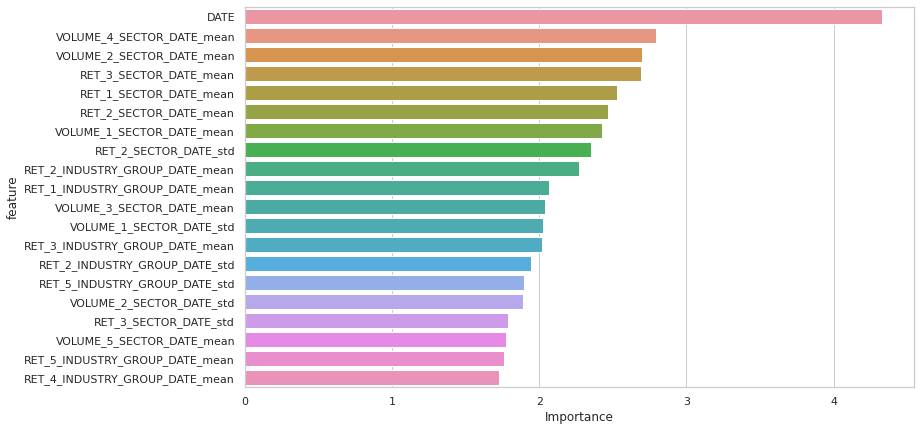

In [ ]:
train_pool = Pool(train_x, train_y)
feature_importances = CB_CF.get_feature_importance(train_pool)
importances = pd.DataFrame(sorted(zip(feature_importances, train_x.columns), reverse=True),
                  columns = ['Importance', 'feature'])

plt.figure(figsize=(12,7))
sns.set_theme(style="whitegrid")
sns.barplot(data=importances.iloc[:20], y = 'feature', x= 'Importance');

In [ ]:
# Make a submission
y_pred = CB_CF.predict(test)=='True'
submission = pd.Series(y_pred)
submission.index = test.index
submission.name = 'RET'
submission.to_csv('submission.csv', index=True, header=True)

# Artificial Neural Network

In [ ]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=1, max_iter=300, hidden_layer_sizes=(300,150,50),
                    early_stopping=True, n_iter_no_change=10,
                    verbose = True)
clf.fit(train_x.fillna(0), train_y)
acc = clf.score(train_x.fillna(0), train_y)
print(f'Accuracy in Training Set: {acc:.2f} % ')

Iteration 1, loss = inf
Validation score: 0.498208
Iteration 2, loss = 0.81367115
Validation score: 0.502150
Iteration 3, loss = 0.74985590
Validation score: 0.498358
Iteration 4, loss = 0.71197066
Validation score: 0.502508
Iteration 5, loss = 0.69663906
Validation score: 0.500538
Iteration 6, loss = 0.69467871
Validation score: 0.499672
Iteration 7, loss = 0.69340833
Validation score: 0.502508
Iteration 8, loss = 0.69325704
Validation score: 0.501971
Iteration 9, loss = 0.69319333
Validation score: 0.498567
Iteration 10, loss = 0.69338189
Validation score: 0.501374
Iteration 11, loss = 0.69335995
Validation score: 0.498716
Iteration 12, loss = 0.69346460
Validation score: 0.501433
Iteration 13, loss = 0.69352898
Validation score: 0.501403
Iteration 14, loss = 0.69342445
Validation score: 0.501403
Iteration 15, loss = 0.69335644
Validation score: 0.498567
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy in Training Set: 0.50 % 


In [ ]:
y_pred = clf.predict(valid_x.fillna(0))
acc = accuracy_score(valid_y, y_pred) * 100
print(f'Accuracy in validation Set: {acc:.2f} % ')

Accuracy in validation Set: 50.08 % 


In [ ]:
print('Classification report :\n' + classification_report(valid_y, y_pred))
print('Confusion Matrix :')
print(confusion_matrix(valid_y, y_pred))

Classification report :
              precision    recall  f1-score   support

       False       0.50      0.99      0.67     41838
        True       0.56      0.01      0.02     41881

    accuracy                           0.50     83719
   macro avg       0.53      0.50      0.34     83719
weighted avg       0.53      0.50      0.34     83719

Confusion Matrix :
[[41523   315]
 [41480   401]]


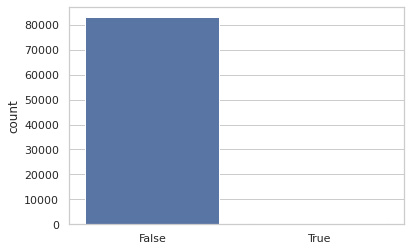

In [ ]:
sns.countplot(x = y_pred);